In [1]:
%pylab inline
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from multiprocessing import Pool
from functools import partial 
from pyswarm import pso
import warnings
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

# time line
T_min = 20
T_max = 90
T_y = 65
beta = 1/(1+0.02)
# States of the economy, GOOD or BAD, {1 : GOOD}, {0 : BAD}
S = [0,1]
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
P = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate 
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])

    
#Define the utility function
def u(c):
    gamma = 2
    return (np.float_power(c,1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth 
def uB(w):
    B = 2
    return B*u(w)
        

# Define deterministic function to captures the hump shape of life-cycle earnings.
ageTick = [20, 50, 60, 65, T_max]
earning = [35, 100, 70, 35, 35]
linearFit = interp1d(ageTick, earning, kind = "linear")
detEarning = np.array(linearFit(np.linspace(T_min, T_max, T_max - T_min + 1)))

def y(age, s):
    if age <= T_y:
        return detEarning[age-T_min-1] * earningShock[s]
    else:
        return detEarning[age-T_min-1]


# Define the transtiion of state 
def transition(s, a):
    '''
        Input: Z is a tuple containing states variables: (w, s) which is the current wealth and econ state
               a is the action taken with contains variables: (c, b, k) which is the combination of consumption, bond and stock
        Output: the next possible states with corresponding probabilities
    '''
    c, b, k = a
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[s]
    r_stock = r_m[s]
    w_next =  b*(1+r_bond) + k*(1+r_stock)
    return w_next

Populating the interactive namespace from numpy and matplotlib


In [2]:
# timeline is from age 15 - 80, use approximation for value function from age 15 - 79 by discretizing the state space
# since we know the terminal condition. Here XX is the grid point collection. Initiate the grid and corresponding value.

# This function is used to generate power grid 
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)

w_grid_size = 100
w_lower = 0
w_upper = 20000
T = T_max - T_min
wgrid = powspace(w_lower, w_upper, 3, num = w_grid_size)
# wgrid = np.linspace(w_lower, w_upper, num = w_grid_size)

print("Shape of grid w grid: ", wgrid.shape)
# V use to store the value 
V_t = np.zeros((w_grid_size,len(S),T))
C_t = np.zeros((w_grid_size,len(S),T))
B_t = np.zeros((w_grid_size,len(S),T))
K_t = np.zeros((w_grid_size,len(S),T))
print("Shape of Value matrix: ", V_t.shape)

# Calculate terminal value function 
V_t[:, 0, T-1] = u(y(T_max,0) + wgrid)
V_t[:, 1, T-1] = u(y(T_max,1) + wgrid)
C_t[:, 0, T-1] = y(T_max,0) + wgrid
C_t[:, 1, T-1] = y(T_max,1) + wgrid
B_t[:, 0, T-1] = 0
B_t[:, 1, T-1] = 0
K_t[:, 0, T-1] = 0
K_t[:, 1, T-1] = 0

Shape of grid w grid:  (100,)
Shape of Value matrix:  (100, 2, 70)


In [3]:
# Definition of the value function, return of the funciton is the value of the function and the coresponding policy
def V(w, s, t, model):
    def obj(bkTheta):
        bk, theta = bkTheta
        b = bk * theta
        k = bk * (1-theta)
        c = y(t,s) + w - bk
        if c <= 0:
            return 9999999999
        w_next = transition(s, (c, b, k))
        V_next = np.array([model[state](w_next[state]) for state in S])
        return -(u(c) + beta * np.dot(V_next, P[s]))
    
    lb = [0, 0]
    ub = [y(t,s) + w , 1]
    xopt, fopt = pso(obj, lb, ub)
    max_val = -fopt
    bk, the = xopt
    return np.array([max_val, [bk*the, bk*(1-the)]])

In [4]:
%%time 
pool = Pool()
# Set value to the grid by backward induction 
for t in range(T_max - 1, T_min - 1, -1):
    print(t)
    tt = t-T_min-1
    cs = [interp1d(wgrid, V_t[:,0,tt+1], kind = "cubic", fill_value="extrapolate"),
          interp1d(wgrid, V_t[:,1,tt+1], kind = "cubic", fill_value="extrapolate")]    
    for s in S:                                               
        f = partial(V, s = s, t = t, model = cs)
        results = np.array(pool.map(f, wgrid))
        V_t[:,s,tt] = results[:,0]
#        B_t[:,s,tt] = np.array([b for b in results[:,1]])
        B_t[:,s,tt] = np.array([b[0] for b in results[:,1]])
        K_t[:,s,tt] = np.array([k[1] for k in results[:,1]])
        C_t[:,s,tt] = wgrid + y(t,s) - B_t[:,s,tt] - K_t[:,s,tt]
pool.close()

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
CPU times: user 8.29 s, sys: 1.1 s, total: 9.4 s
Wall time: 4min 52s


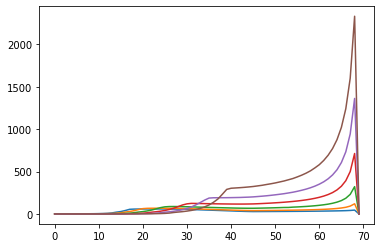

In [5]:
from matplotlib import pyplot as plt
plt.plot(C_t[10,1,:])
plt.plot(C_t[20,1,:])
plt.plot(C_t[30,1,:])
plt.plot(C_t[40,1,:])
plt.plot(C_t[50,1,:])
plt.plot(C_t[60,1,:])

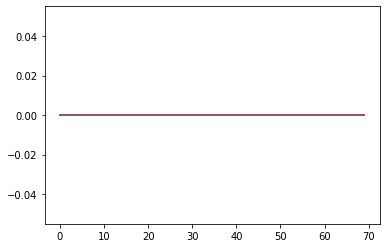

In [6]:
plt.plot(B_t[10,1,:])
plt.plot(B_t[20,1,:])
plt.plot(B_t[30,1,:])
plt.plot(B_t[40,1,:])
plt.plot(B_t[50,1,:])
plt.plot(B_t[60,1,:])

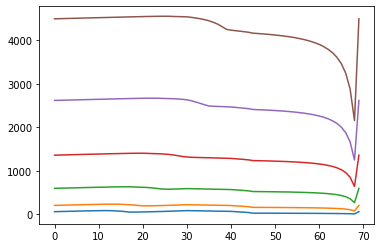

In [7]:
plt.plot(K_t[10,1,:])
plt.plot(K_t[20,1,:])
plt.plot(K_t[30,1,:])
plt.plot(K_t[40,1,:])
plt.plot(K_t[50,1,:])
plt.plot(K_t[60,1,:])

### Simulation Part

In [8]:
import quantecon as qe
mc = qe.MarkovChain(P)

def action(t, w, s):
    c = interp1d(wgrid, C_t[:,s,t], kind = "nearest", fill_value = "extrapolate")(w)
    b = interp1d(wgrid, B_t[:,s,t], kind = "nearest", fill_value = "extrapolate")(w)
    k = interp1d(wgrid, K_t[:,s,t],kind = "nearest", fill_value = "extrapolate")(w)
    return (c,b,k)
    
# Define the transtiion of state 
def fixTransition(w, s, s_next, a):
    c, b, k = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    r_bond = r_f[int(s)]
    r_stock = r_m[s,s_next]
    w_next = b*(1+r_bond) + k*(1+r_stock)
    return w_next

In [9]:
def simulation(simulations = 1000):
    for sim in range(simulations):
        if sim%100 == 0:
            print(sim)
        # simulate an agent age 15 starting with wealth of 10
        w = 20
        wealth = []
        Consumption = []
        Bond = []
        Stock = []
        econState = mc.simulate(ts_length=60)
        for t in range(len(econState)-1):
            wealth.append(w)
            s = econState[t]
            s_next = econState[t+1]
            a = action(t, w, s)
            Consumption.append(a[0])
            Bond.append(a[1])
            Stock.append(a[2])
            w = fixTransition(w,s,s_next, a)
        # dictionary of lists  
        dictionary = {'wealth': wealth,
                      'Consumption': Consumption, 
                      'Bond': Bond, 
                      'Stock': Stock}  
        if sim == 0:
            df = pd.DataFrame(dictionary) 
        else:
            df = df + pd.DataFrame(dictionary) 
            
    return df 

In [10]:
df = simulation(simulations = 1000)

0
100
200
300
400
500
600
700
800
900


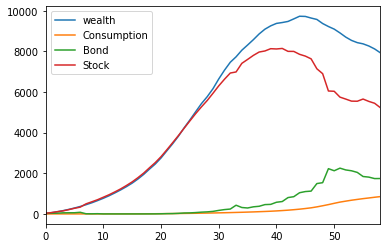

In [11]:
(df/1000).plot()